# Place Connectivity Index and Covid-19

In [2]:
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
import numpy as np

# For t-tests
from scipy import stats
from scipy.stats import shapiro, levene

# For GWR
import mgwr
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
from mgwr.utils import shift_colormap, truncate_colormap
from shapely.geometry import Point

## Read data
### 2018 Census county boundaries

- Downloaded from https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html

In [3]:
bounds = gpd.read_file(
    'datasets_extra/cb_2018_us_county_20m.zip'
).filter([
    'GEOID', 'NAME', 'geometry'
])

bounds.columns = ['fips', 'name', 'geometry']

bounds

,fips,name,geometry
0,37017,Bladen,"POLYGON ((-78.90200 34.83527, -78.79960 34.850..."
1,37167,Stanly,"POLYGON ((-80.49737 35.20210, -80.29542 35.502..."
2,39153,Summit,"POLYGON ((-81.68699 41.13596, -81.68495 41.277..."
3,42113,Sullivan,"POLYGON ((-76.81373 41.59003, -76.22014 41.541..."
4,48459,Upshur,"POLYGON ((-95.15274 32.66095, -95.15211 32.902..."
...,...,...,...
3215,38005,Benson,"POLYGON ((-99.84661 48.37130, -99.49292 48.370..."
3216,72079,Lajas,"POLYGON ((-67.10904 18.05608, -67.06791 18.066..."
3217,31159,Seward,"POLYGON ((-97.36812 41.04695, -96.91094 41.046..."
3218,37023,Burke,"POLYGON ((-81.90665 35.88338, -81.94319 35.960..."


### County-level place connectivity index - PCI (2019)

In [11]:
pci = (
    pd.read_csv(
        'datasets_li/US_County_PCI_2019.csv',
        dtype={'place_i': 'str'}
    )
    .groupby('place_i')
    [['pci']].sum()
    .reset_index()
    .rename(columns={'place_i': 'fips'})
    .assign(
        pci_cat=lambda df_: pd.qcut(
            df_.pci,
            [0, 0.2, 0.4, 0.6, 0.8, 1.0],
            labels=['very low', 'low', 'medium', 'high', 'very high']
        )
    )
    .filter(['pci_cat', 'pci', 'fips'])
)

pci

,pci_cat,pci,fips
0,very high,8078.268,01001
1,very high,10194.793,01003
2,medium,4902.281,01005
3,medium,4687.708,01007
4,very low,3146.959,01009
...,...,...,...
3102,very high,12562.222,56037
3103,very high,10525.378,56039
3104,very high,10532.539,56041
3105,low,4377.208,56043


In [14]:
pci['pci_cat'].value_counts()

pci_cat
very low     622
very high    622
low          621
medium       621
high         621
Name: count, dtype: int64

In [13]:
assert pci['pci'].isna().sum() == 0, "Some PCI values are 0! Fix!"

### Median Age

In [15]:
age = (
    pd.read_csv(
        'datasets_extra/ACSDT5Y2019.B01002-Data.csv',
        skiprows=1
    )
    .filter(['Geography', 'Estimate!!Median age --!!Total:'])
    .assign(Geography=lambda df_: df_.Geography.str.split('US').str[-1])
)

age.columns = ['fips', 'age']

age

,fips,age
0,01001,38.2
1,01003,43.0
2,01005,40.4
3,01007,40.9
4,01009,40.7
...,...,...
3215,72145,41.5
3216,72147,47.0
3217,72149,40.1
3218,72151,42.9


In [16]:
hh_income = (
    pd.read_csv(
        'datasets_extra/ACSDT5Y2019.B19013-Data.csv',
        skiprows=1
    )
    .filter(['Geography', 'Estimate!!Median household income in the past 12 months (in 2019 inflation-adjusted dollars)'])
    .assign(Geography=lambda df_: df_.Geography.str.split('US').str[-1])
)

hh_income.columns = ['fips', 'hh_income']

hh_income

,fips,hh_income
0,01001,58731
1,01003,58320
2,01005,32525
3,01007,47542
4,01009,49358
...,...,...
3215,72145,19617
3216,72147,14936
3217,72149,19877
3218,72151,16295


In [17]:
bachelors = (
    pd.read_csv(
        'datasets_extra/ACSST5Y2019.S1501-Data.csv',
        skiprows=1
    )
    .assign(
        Geography=lambda df_: df_.Geography.str.split('US').str[-1],
        bachelors=lambda df_: \
            df_["Estimate!!Total!!AGE BY EDUCATIONAL ATTAINMENT!!Population 25 years and over!!Bachelor's degree or higher"] \
            / df_["Estimate!!Total!!AGE BY EDUCATIONAL ATTAINMENT!!Population 25 years and over"] \
            * 100
    )
    .filter(['Geography', 'bachelors'])
)

bachelors.columns = ['fips', 'bachelors']

bachelors

/var/folders/w6/kmxyhb092_3gsgy99f9_t01r0000gn/T/ipykernel_28306/1992937972.py:2: DtypeWarning: Columns (122,123,124,125,192,193,194,195,228,229,230,231,234,235,236,237,244,245,378,379,380,381,388,389,390,391,392,393,394,395,436,437,438,439,448,449,450,451,490,491,492,493,500,501,630,631,644,645,646,647,648,649,650,651,680,681,682,683,704,705,706,707,746,747,748,749,750,751,756,757) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv(


,fips,bachelors
0,01001,26.571574
1,01003,31.862460
2,01005,11.578713
3,01007,10.378525
4,01009,13.093413
...,...,...
3215,72145,21.222300
3216,72147,17.999358
3217,72149,19.912819
3218,72151,18.003019


In [18]:
insured = (
    pd.read_csv(
        'datasets_extra/ACSST5Y2019.S2701-Data.csv',
        skiprows=1
    )
    .assign(
        Geography=lambda df_: df_.Geography.str.split('US').str[-1],
        insured=lambda df_: \
            df_["Estimate!!Insured!!Civilian noninstitutionalized population"] \
            / df_["Estimate!!Total!!Civilian noninstitutionalized population"] \
            * 100
    )
    .filter(['Geography', 'insured'])
)

insured.columns = ['fips', 'insured']

insured

/var/folders/w6/kmxyhb092_3gsgy99f9_t01r0000gn/T/ipykernel_28306/3027006613.py:2: DtypeWarning: Columns (250,251,258,259,290,291,298,299,300,301,302,303,308,309,326,327,334,335,356,357,494,495,502,503,534,535,542,543,544,545,546,547,552,553,570,571,578,579,600,601) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv(


,fips,insured
0,01001,92.931515
1,01003,91.118138
2,01005,88.680756
3,01007,89.332105
4,01009,89.235717
...,...,...
3215,72145,90.490845
3216,72147,87.965749
3217,72149,96.246240
3218,72151,94.963384


## Covid-19 for the year 2020 (NYTimes)
- The dates are reported cumulatively (so previous total for each date)
- We want to get monthly dates, so extact only the final day of each month from March onwards
- We also want get new monthly cases/deaths, not cumulative- subtract previous month

In [19]:
covid20_ = (
    pd.read_csv(
        'datasets_extra/nytimes-covid/us-counties-2020.csv',
        dtype={'fips': str}
    )
    .dropna(subset=['fips'])
    .assign(
        month=lambda df_: df_.date.str[:-3]
    )
    .sort_values(['fips', 'month'])
    .groupby(['fips', 'month'])
    [['cases', 'deaths']]
    .max()
    .sort_index()
)

covid20_.fillna(0, inplace=True)

In [20]:
covid20_

cases  deaths
fips  month                 
01001 2020-03      7     0.0
      2020-04     43     4.0
      2020-05    221     4.0
      2020-06    537    12.0
      2020-07   1015    21.0
...              ...     ...
78030 2020-08    680    10.0
      2020-09    764    13.0
      2020-10    796    14.0
      2020-11    869    15.0
      2020-12   1028    15.0

[30396 rows x 2 columns]

In [37]:
covid20 = (
    covid20_
    .groupby(level=0)
    .diff()
    .fillna(covid20_)
    .reset_index()
    .fillna(0)
)

In [38]:
covid20

,fips,month,cases,deaths
0,01001,2020-03,7.0,0.0
1,01001,2020-04,36.0,4.0
2,01001,2020-05,178.0,0.0
3,01001,2020-06,316.0,8.0
4,01001,2020-07,478.0,9.0
...,...,...,...,...
30391,78030,2020-08,546.0,6.0
30392,78030,2020-09,84.0,3.0
30393,78030,2020-10,32.0,1.0
30394,78030,2020-11,73.0,1.0


### The months' cases and deaths

In [39]:
# Calculate 'month_deaths_ratio' while handling division by zero
# There are 5 samples where cases = 0 but deaths = 1, ignore those
covid20['month_deaths_ratio'] = (
    covid20.apply(
        lambda x: 0 if x['cases'] == 0 else x['deaths'] / x['cases'],
        axis=1
    )
)

In [40]:
assert covid20.month_deaths_ratio.isna().sum() == 0, \
    "Whoops! Ratios should not be null!"

In [43]:
# Pivot cases by month
cases_months = (
    covid20
    .pivot(index='fips', columns='month', values='cases')
    .fillna(0)
)
cases_months.columns = [ f'cases_{x[5:]}' for x in cases_months.columns ]
cases_months.reset_index(inplace=True)

# Pivot deaths by month
deaths_months = (
    covid20
    .pivot(index='fips', columns='month', values='deaths')
    .fillna(0)
)
deaths_months.columns = [ f'deaths_{x[5:]}' for x in deaths_months.columns ]
deaths_months.reset_index(inplace=True)

# Pivot death ratios by month
month_deaths_ratio = (
    covid20
    .pivot(index='fips', columns='month', values='month_deaths_ratio')
    .fillna(0)
)
month_deaths_ratio.columns = [ f'month_deathsratio_{x[5:]}' for x in month_deaths_ratio.columns ]
month_deaths_ratio.reset_index(inplace=True)

In [45]:
cases_months

,fips,cases_01,cases_02,cases_03,cases_04,cases_05,cases_06,cases_07,cases_08,cases_09,cases_10,cases_11,cases_12
0,01001,0.0,0.0,7.0,36.0,178.0,316.0,478.0,427.0,349.0,368.0,621.0,1410.0
1,01003,0.0,0.0,19.0,155.0,116.0,390.0,2421.0,1444.0,1095.0,1300.0,1950.0,4711.0
2,01005,0.0,0.0,0.0,39.0,128.0,158.0,273.0,159.0,139.0,164.0,118.0,336.0
3,01007,0.0,0.0,3.0,39.0,33.0,95.0,193.0,191.0,110.0,209.0,323.0,638.0
4,01009,0.0,0.0,5.0,32.0,25.0,146.0,559.0,520.0,342.0,445.0,923.0,1644.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3213,72151,0.0,0.0,0.0,0.0,12.0,24.0,56.0,111.0,120.0,164.0,98.0,155.0
3214,72153,0.0,0.0,0.0,0.0,53.0,37.0,104.0,122.0,99.0,172.0,149.0,142.0
3215,78010,0.0,0.0,0.0,27.0,3.0,15.0,211.0,166.0,73.0,17.0,78.0,239.0
3216,78020,0.0,0.0,0.0,2.0,0.0,2.0,12.0,21.0,23.0,8.0,17.0,89.0


### Hospitals
- Get counts by county (fips)
- Source: https://www.kaggle.com/datasets/andrewmvd/us-hospital-locations

In [46]:
hospitals = (
    pd.read_csv(
        'datasets_extra/us_hospital_locations.csv'
    )
    .groupby('COUNTYFIPS')
    .size()
    .reset_index()
    .rename(columns={
        0: 'hospitals',
        'COUNTYFIPS': 'fips'
    })
)
hospitals

,fips,hospitals
0,01001,1
1,01003,4
2,01005,1
3,01007,1
4,01009,1
...,...,...
2572,72141,1
2573,72145,1
2574,72147,1
2575,72153,1


In [47]:
hospitals.fips.nunique()

2577

### Population counts

In [48]:
pop19 = (
    pd.read_csv(
        'datasets_extra/ACSDT5Y2019.B01001-Data.csv',
        skiprows=1,
        usecols=[0, 2]
    )
    .assign(
        Geography=lambda df_: df_.Geography.str.split('US').str[-1],
    )
    .dropna()
)

pop19.columns = ['fips', 'pop19']

pop19

,fips,pop19
0,01001,55380
1,01003,212830
2,01005,25361
3,01007,22493
4,01009,57681
...,...,...
3215,72145,52192
3216,72147,8642
3217,72149,22403
3218,72151,33499


### Combine

In [52]:
combined = (
    bounds
    .merge(pop19, on='fips', how='left')
    .merge(age, on='fips', how='left')
    .merge(hh_income, on='fips', how='left')
    .merge(insured, on='fips', how='left')
    .merge(bachelors, on='fips', how='left')
    .merge(pci, on='fips', how='left')
    .merge(hospitals, on='fips', how='left')
    .merge(cases_months, on='fips', how='left')
    .merge(deaths_months, on='fips', how='left')
    .merge(month_deaths_ratio, on='fips', how='left')
)

combined

,fips,name,geometry,pop19,age,hh_income,insured,bachelors,pci_cat,pci,...,month_deathsratio_03,month_deathsratio_04,month_deathsratio_05,month_deathsratio_06,month_deathsratio_07,month_deathsratio_08,month_deathsratio_09,month_deathsratio_10,month_deathsratio_11,month_deathsratio_12
0,37017,Bladen,"POLYGON ((-78.90200 34.83527, -78.79960 34.850...",33407,44.5,36173,87.085183,15.814943,very low,2748.868,...,0.000000,0.000000,0.025000,0.003704,0.020833,0.019608,0.023923,0.022989,0.000000,0.010000
1,37167,Stanly,"POLYGON ((-80.49737 35.20210, -80.29542 35.502...",61588,42.2,52623,88.824477,17.322360,low,4182.453,...,0.000000,0.166667,0.000000,0.003333,0.012295,0.032051,0.047710,0.038549,0.009311,0.000000
2,39153,Summit,"POLYGON ((-81.68699 41.13596, -81.68495 41.277...",541334,41.0,57181,94.316829,32.457614,very high,9805.822,...,0.038168,0.092243,0.152709,0.060038,0.008907,0.015588,0.017764,0.009135,0.009736,0.019013
3,42113,Sullivan,"POLYGON ((-76.81373 41.59003, -76.22014 41.541...",6135,53.7,47407,92.336134,17.198618,very low,2087.819,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.024390
4,48459,Upshur,"POLYGON ((-95.15274 32.66095, -95.15211 32.902...",41018,41.4,52162,83.278154,17.091444,low,3686.578,...,0.000000,0.000000,0.000000,0.000000,0.014815,0.028777,0.060606,0.041667,0.074468,0.007276
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3215,38005,Benson,"POLYGON ((-99.84661 48.37130, -99.49292 48.370...",6873,30.5,47667,88.984409,16.155419,very low,2817.916,...,0.000000,0.000000,0.000000,0.000000,0.012195,0.020979,0.017241,0.019802,0.017241,0.009479
3216,72079,Lajas,"POLYGON ((-67.10904 18.05608, -67.06791 18.066...",22835,45.0,13992,95.379350,15.319044,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3217,31159,Seward,"POLYGON ((-97.36812 41.04695, -96.91094 41.046...",17171,38.0,70389,94.908230,28.888480,medium,4656.636,...,0.000000,0.125000,0.000000,0.000000,0.000000,0.014286,0.013333,0.000000,0.007310,0.043321
3218,37023,Burke,"POLYGON ((-81.90665 35.88338, -81.94319 35.960...",89968,44.1,44557,87.930877,16.438209,high,7264.207,...,0.000000,0.082474,0.019868,0.009539,0.009921,0.015974,0.041096,0.016181,0.009756,0.004989


Text(0.5, 1.0, 'Aggregated Place Connectivity Index, by County')

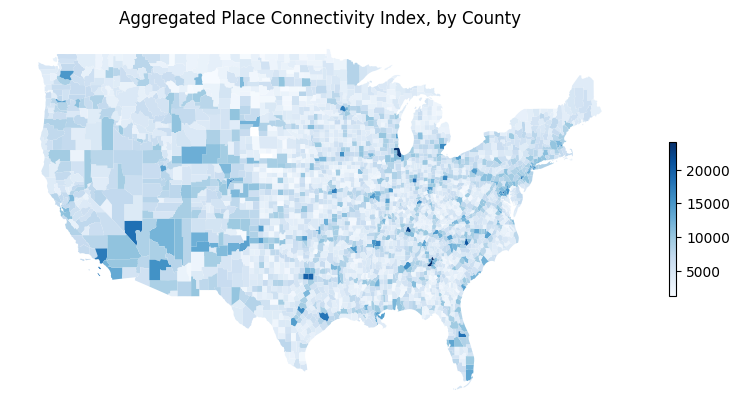

In [87]:
(
    combined
    .plot(
        column='pci',
        cmap='Blues',
        legend=True,
        figsize=(10, 5),
        legend_kwds={'shrink': 0.4}
    )
)

plt.axis('off')
plt.title('Aggregated Place Connectivity Index, by County')

- Some counties have missing PCI and hence pci_cat
- We tried interpolating the values by looking at the neighbours, but neighbours in most cases would also have None values making the task difficult
- So we decided to drop counties where pci_cat is none

In [112]:
combined = combined.dropna(subset=['pci_cat'])

In [158]:
# 1. 定义月份列表
def plotdeathratio_bygroup(df):
    months = ['03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
    
    fig, axes = plt.subplots(
        nrows=1, ncols=len(df['pci_cat'].unique()), figsize=(15, 5)
    )

    grouped = (
        combined.groupby('pci_cat')[[f'deaths_{m}' for m in months]].sum().div(
            combined.groupby('pci_cat')[[f'cases_{m}' for m in months]].sum().values
        )
    )

    grouped.columns = [f'drate_{m}' for m in months]

    i = 0
    for group in grouped.index.categories:
        
        axes[i].plot(
            months,
            grouped.loc[group][['drate_' + m for m in months]].values,
            label=group
        )
        axes[i].set_xlabel('Month')
        axes[i].set_ylabel('Cases / Deaths')
        axes[i].set_title(group.title())
        axes[i].set_ylim(0.005, 0.06)
        i += 1

    plt.tight_layout()
    plt.show()

/var/folders/w6/kmxyhb092_3gsgy99f9_t01r0000gn/T/ipykernel_28306/3301028809.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  combined.groupby('pci_cat')[[f'deaths_{m}' for m in months]].sum().div(
/var/folders/w6/kmxyhb092_3gsgy99f9_t01r0000gn/T/ipykernel_28306/3301028809.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  combined.groupby('pci_cat')[[f'cases_{m}' for m in months]].sum().values


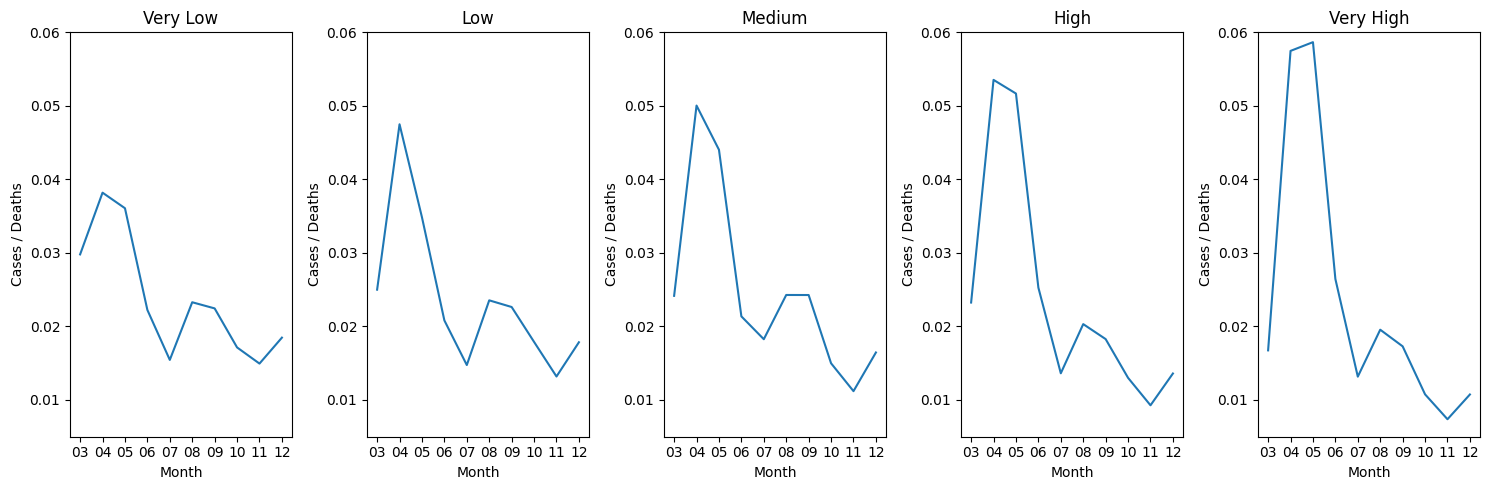

In [159]:
plotdeathratio_bygroup(combined)

#### Correlation analysis

In [221]:
annual = (
    covid20
    .query('month == "2020-04"')
    .groupby('fips')
    [['cases', 'deaths']]
    .sum()
    .assign(
        drate=lambda x: (x.deaths / x.cases).fillna(0)
    )
    .reset_index()
    .merge(pci, how='left', on='fips')
    .dropna(subset=['pci_cat'])
)

In [229]:
annual.groupby('pci_cat').drate.mean()

/var/folders/w6/kmxyhb092_3gsgy99f9_t01r0000gn/T/ipykernel_28306/3379648710.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  annual.groupby('pci_cat').drate.mean()


pci_cat
very low          inf
low          0.042378
medium       0.040978
high         0.044421
very high    0.043891
Name: drate, dtype: float64

In [227]:
np.corrcoef(annual.drate, annual.pci)

/Users/ilya/miniconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2742: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


array([[nan, nan],
       [nan,  1.]])

In [172]:
covid20

,fips,month,cases,deaths,month_deaths_ratio
0,01001,2020-03,7.0,0.0,0.000000
1,01001,2020-04,36.0,4.0,0.111111
2,01001,2020-05,178.0,0.0,0.000000
3,01001,2020-06,316.0,8.0,0.025316
4,01001,2020-07,478.0,9.0,0.018828
...,...,...,...,...,...
30391,78030,2020-08,546.0,6.0,0.010989
30392,78030,2020-09,84.0,3.0,0.035714
30393,78030,2020-10,32.0,1.0,0.031250
30394,78030,2020-11,73.0,1.0,0.013699


<>:12: SyntaxWarning: invalid escape sequence '\T'
<>:12: SyntaxWarning: invalid escape sequence '\T'
C:\Users\yl\AppData\Local\Temp\ipykernel_26680\2578382947.py:12: SyntaxWarning: invalid escape sequence '\T'
  plt.savefig("output\The death rate of covid among different pic group during 2020.jpg")
C:\Users\yl\AppData\Local\Temp\ipykernel_26680\2578382947.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_covid=combined.groupby('pci_cat').agg({'cases': 'sum', 'deaths': 'sum'})


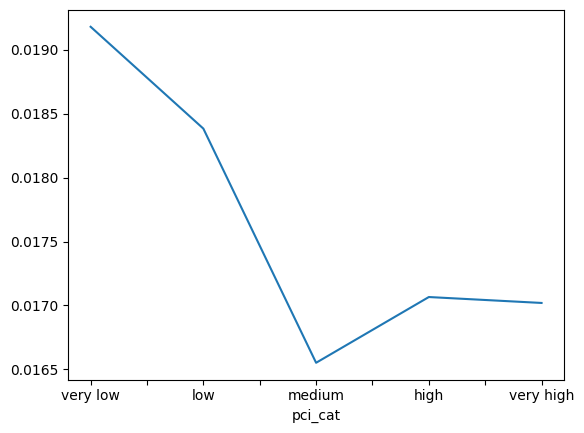

In [58]:
group_covid = combined.groupby('pci_cat').agg({'cases': 'sum', 'deaths': 'sum'})
group_covid['deaths_ratio']=group_covid['deaths']/group_covid['cases']


# Plot cases and deaths on the left y-axis
# group_covid[['cases', 'deaths']].plot(kind='line', secondary_y='deaths')

# Plot deaths_ratio on the right y-axis
# group_covid['deaths_ratio'].plot(kind='line', secondary_y=True, ax=plt.twinx())
group_covid['deaths_ratio'].plot(kind='line')
# plt.title('The death rate of covid among different pic group during 2020')
plt.savefig("output\The death rate of covid among different pic group during 2020.jpg")
plt.show()



In [270]:

combined['pci_log10'] = np.log10(combined['pci'])

c:\Users\yl\AppData\Local\Programs\Python\Python312\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [ ]:
combined.plot.scatter(x='pci_log10', y='month_deathsratio_12', s=0.1)

In [ ]:
combined.plot.scatter(x='pci', y='deaths_08_y', s=0.1)

In [183]:
combined.to_file('output/output.gpkg')

In [271]:
#combined
combined.loc[:, 'pop19':].corr()

,pop19,age,hh_income,insured,bachelors,hospitals,cases,deaths,year_deathratio,index_x,...,month_deathsratio_04,month_deathsratio_05,month_deathsratio_06,month_deathsratio_07,month_deathsratio_08,month_deathsratio_09,month_deathsratio_10,month_deathsratio_11,month_deathsratio_12,pci_log10
pop19,1.000000,-0.192092,0.290129,0.040830,0.397202,0.898692,0.954829,0.895953,-0.000818,-0.010301,...,0.053307,0.040591,0.063335,0.043752,-0.003965,0.036520,-0.038862,-0.092930,-0.090053,0.356460
age,-0.192092,1.000000,-0.120570,0.247283,-0.179128,-0.193225,-0.203146,-0.147513,0.126572,0.011455,...,0.005781,-0.000914,0.016967,-0.013786,0.055262,0.029906,-0.004761,0.054077,0.120550,-0.268164
hh_income,0.290129,-0.120570,1.000000,0.348138,0.698124,0.209205,0.236012,0.225329,-0.156241,0.089429,...,0.026413,0.006670,0.064190,-0.005441,-0.071897,0.006195,-0.139576,-0.211023,-0.056895,0.231875
insured,0.040830,0.247283,0.348138,1.000000,0.326857,-0.000586,0.011251,0.020271,-0.151007,-0.109891,...,0.028336,0.048095,0.078859,-0.090978,-0.036195,-0.016484,-0.165243,-0.265267,0.048957,0.067908
bachelors,0.397202,-0.179128,0.698124,0.326857,1.000000,0.348677,0.333635,0.297377,-0.146204,0.067760,...,0.042059,0.026262,0.051455,-0.018060,-0.041444,0.036865,-0.160467,-0.195740,-0.092704,0.325089
hospitals,0.898692,-0.193225,0.209205,-0.000586,0.348677,1.000000,0.878569,0.784664,0.006797,0.018891,...,0.042289,0.053696,0.047636,0.048292,-0.000196,0.039951,-0.031953,-0.086329,-0.094726,0.372494
cases,0.954829,-0.203146,0.236012,0.011251,0.333635,0.878569,1.000000,0.904636,-0.018966,-0.024650,...,0.043080,0.028893,0.049906,0.029295,-0.009828,0.015621,-0.037727,-0.085543,-0.076883,0.331821
deaths,0.895953,-0.147513,0.225329,0.020271,0.297377,0.784664,0.904636,1.000000,0.116248,-0.045436,...,0.061415,0.055850,0.119596,0.087598,0.002509,0.066594,-0.010158,-0.055577,-0.044255,0.294675
year_deathratio,-0.000818,0.126572,-0.156241,-0.151007,-0.146204,0.006797,-0.018966,0.116248,1.000000,-0.045774,...,0.113097,0.116859,0.182426,0.235759,0.140539,0.228125,0.277771,0.490225,0.451209,-0.093250
index_x,-0.010301,0.011455,0.089429,-0.109891,0.067760,0.018891,-0.024650,-0.045436,-0.045774,1.000000,...,-0.026841,-0.036311,-0.062254,0.059111,0.015705,-0.011808,0.012217,-0.008863,-0.038340,0.036426


#### T-test

##### T-test by group


In [43]:
# Get the unique values of different groups
groups = combined['pci_cat'].unique()
print(groups)
# Perform independent sample t-test
for group in groups:
    group_data_x = combined[combined['pci_cat'] == group]['pci']

    group_data_y = combined[combined['pci_cat'] == group]['month_deathsratio_08']
    # # Shapiro-Wilk test for normality
    stat_x, p_x = shapiro(group_data_x)
    stat_y, p_y = shapiro(group_data_y)

    print("Shapiro-Wilk test for normality:")
    print("Data X - Statistic:", stat_x, "p-value:", p_x)
    print("Data Y - Statistic:", stat_y, "p-value:", p_y)
    
    t_stat, p_val = stats.ttest_ind(group_data_x, group_data_y)
    
    print(f"Independent sample t-test result for {group}:")
    print("t statistic:", t_stat)
    print("p value:", p_val)

['very low', 'low', 'high', 'medium', 'very high']
Categories (5, object): ['very low' < 'low' < 'medium' < 'high' < 'very high']


KeyError: 'month_deathsratio_08'

##### T-test by all the data

In [44]:

all_data_x = combined['pci']
    # print(group_data_x)
all_data_y = combined['year_deathratio']
# 正态分布检验
stat_x, p_x = shapiro(all_data_x)
stat_y, p_y = shapiro(all_data_y)

print("Shapiro-Wilk test for normality:")
print("Data X - Statistic:", stat_x, "p-value:", p_x)
print("Data Y - Statistic:", stat_y, "p-value:", p_y)


t_stat, p_val = stats.ttest_ind(all_data_x, all_data_y)

print("t statistic:", t_stat)
print("p value:", p_val)

Shapiro-Wilk test for normality:
Data X - Statistic: 0.9391866142313033 p-value: 1.577593349312175e-32
Data Y - Statistic: nan p-value: nan
t statistic: nan
p value: nan


## Get cumulative Covid-19 cases (NY Times), correlation analysis,t-test
+ The relationship between pci and year_deaths_ratio is ==negative during the whole year==,also t test shows that the two are significantly different at the 1% significance level.
+ The relationship between pci and aggregate deaths ratio before 8.30 is positive, passing the t test

In [75]:
pci_counties=pd.read_csv(
        'datasets_extra/US_County_PCI_2019.csv',
        dtype={'place_i': 'str'}
    ).groupby('place_i')[['pci']].sum().reset_index() .rename(columns={'place_i': 'fips'})

In [131]:
covid20_year= pd.read_csv(
        'datasets_extra/nytimes-covid/us-counties-2020.csv',
        dtype={'fips': str}
    ).dropna(subset=['fips'])
covid20_12=covid20_year.groupby('fips').max()
covid20_12['year_deaths_ratio']=covid20_12.apply(lambda x: 0 if x['cases'] == 0 else x['deaths'] / x['cases'], axis=1)
covid20_12=covid20_12.rename(columns={
        'cases': 'year_cases',
        'deaths': 'year_deaths'
    })

covid20_12.fillna(0).reset_index()
covid20_12=covid20_12.drop(columns=['date','county','state'])
covid20_12

,year_cases,year_deaths,year_deaths_ratio
fips,,,
01001,4190,48.0,0.011456
01003,13601,161.0,0.011837
01005,1514,32.0,0.021136
01007,1834,46.0,0.025082
01009,4641,63.0,0.013575
...,...,...,...
72151,740,NaN,NaN
72153,878,NaN,NaN
78010,829,7.0,0.008444


In [132]:

covid8=covid20_year.query('date == "2020-08-30"')
covid8['bef830_deaths_ratio']=covid8.apply(lambda x: 0 if x['cases'] == 0 else x['deaths'] / x['cases'], axis=1)
covid8=covid8.rename(columns={
        'cases': 'bef830_cases',
        'deaths': 'bef830_deaths'
    })

covid8.fillna(0).reset_index()
covid8=covid8.drop(columns=['date','county','state'])
covid8

C:\Users\yl\AppData\Local\Temp\ipykernel_26680\1722847989.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  covid8['bef830_deaths_ratio']=covid8.apply(lambda x: 0 if x['cases'] == 0 else x['deaths'] / x['cases'], axis=1)


,fips,bef830_cases,bef830_deaths,bef830_deaths_ratio
482673,01001,1438,23.0,0.015994
482674,01003,4525,40.0,0.008840
482675,01005,757,7.0,0.009247
482676,01007,550,7.0,0.012727
482677,01009,1277,10.0,0.007831
...,...,...,...,...
485903,56037,301,2.0,0.006645
485904,56039,429,1.0,0.002331
485905,56041,295,2.0,0.006780
485906,56043,107,5.0,0.046729


In [125]:
pci_counties

,fips,pci
0,10001,2916.794
1,10003,2759.159
2,10005,2906.426
3,1001,2067.434
4,1003,2952.438
...,...,...
3102,9007,1917.149
3103,9009,3053.780
3104,9011,2958.764
3105,9013,1881.205


In [134]:
c=pci_counties.merge(covid20_12,on='fips',how='left').merge(covid8,on='fips',how='left')
c = c.dropna(subset=['year_deaths_ratio'])
c

,fips,pci,year_cases,year_deaths,year_deaths_ratio,bef830_cases,bef830_deaths,bef830_deaths_ratio
0,10001,2916.794,9173.0,167.0,0.018206,2608.0,109.0,0.041794
1,10003,2759.159,33211.0,462.0,0.013911,8139.0,300.0,0.036860
2,10005,2906.426,14936.0,297.0,0.019885,6317.0,195.0,0.030869
53,11001,5764.238,28983.0,786.0,0.027119,13959.0,606.0,0.043413
71,12001,2291.621,15866.0,129.0,0.008131,5193.0,33.0,0.006355
...,...,...,...,...,...,...,...,...
2972,56037,4472.045,2966.0,16.0,0.005394,301.0,2.0,0.006645
2973,56039,3078.576,2138.0,4.0,0.001871,429.0,1.0,0.002331
2974,56041,2885.894,1558.0,7.0,0.004493,295.0,2.0,0.006780
2975,56043,1130.660,780.0,19.0,0.024359,107.0,5.0,0.046729


In [135]:
c.loc[:, 'pci':].corr()

,pci,year_cases,year_deaths,year_deaths_ratio,bef830_cases,bef830_deaths,bef830_deaths_ratio
pci,1.000000,0.496305,0.438217,-0.088489,0.437719,0.394674,0.068685
year_cases,0.496305,1.000000,0.904636,-0.018966,0.956265,0.823621,0.073751
year_deaths,0.438217,0.904636,1.000000,0.116248,0.882030,0.973809,0.176711
year_deaths_ratio,-0.088489,-0.018966,0.116248,1.000000,0.016273,0.140290,0.490136
bef830_cases,0.437719,0.956265,0.882030,0.016273,1.000000,0.829565,0.072704
bef830_deaths,0.394674,0.823621,0.973809,0.140290,0.829565,1.000000,0.208535
bef830_deaths_ratio,0.068685,0.073751,0.176711,0.490136,0.072704,0.208535,1.000000


In [136]:
def t_stat(x,y):
    # 正态分布检验
    stat_x, p_x = shapiro(x)
    stat_y, p_y = shapiro(y)

    print("Shapiro-Wilk test for normality:")
    print("Data X - Statistic:", stat_x, "p-value:", p_x)
    print("Data Y - Statistic:", stat_y, "p-value:", p_y)


    t_stat, p_val = stats.ttest_ind(all_data_x, all_data_y)

    print("t statistic:", t_stat)
    print("p value:", p_val)
    return t_stat,p_val

In [137]:
t_stat(c['year_deaths_ratio'],c['pci'])
t_stat(c['bef830_deaths_ratio'],c['pci'])

Shapiro-Wilk test for normality:
Data X - Statistic: 0.8990047620572307 p-value: 1.2790908767987152e-39
Data Y - Statistic: 0.9405955184150263 p-value: 3.421061183247389e-32
t statistic: 91.56882923100062
p value: 0.0
Shapiro-Wilk test for normality:
Data X - Statistic: nan p-value: nan
Data Y - Statistic: 0.9405955184150263 p-value: 3.421061183247389e-32
t statistic: 91.56882923100062
p value: 0.0


(np.float64(91.56882923100062), np.float64(0.0))

## GWR
+ The independent variable is death_ratio, the dependent variable is pci. Each county has a different coefficient and R2<br>
+ we can fit two GWR. one uses the whole year data. one uses the data from previous months or a certain month
https://deepnote.com/app/carlos-mendez/PYTHON-GWR-and-MGWR-71dd8ba9-a3ea-4d28-9b20-41cc8a282b7a

In [ ]:
combine_gwr= bounds.merge(c, on='fips', how='left')
combine_gwr=combine_gwr .dropna(subset=['pci','year_deaths_ratio','bef830_deaths_ratio'])
combine_gwr

In [159]:
bounds

,fips,name,geometry
0,37017,Bladen,"POLYGON ((-78.902 34.83527, -78.7996 34.85086,..."
1,37167,Stanly,"POLYGON ((-80.49737 35.2021, -80.29542 35.5029..."
2,39153,Summit,"POLYGON ((-81.68699 41.13596, -81.68495 41.277..."
3,42113,Sullivan,"POLYGON ((-76.81373 41.59003, -76.22014 41.541..."
4,48459,Upshur,"POLYGON ((-95.15274 32.66095, -95.15211 32.902..."
...,...,...,...
3215,38005,Benson,"POLYGON ((-99.84661 48.3713, -99.49292 48.3709..."
3216,72079,Lajas,"POLYGON ((-67.10904 18.05608, -67.06791 18.066..."
3217,31159,Seward,"POLYGON ((-97.36812 41.04695, -96.91094 41.046..."
3218,37023,Burke,"POLYGON ((-81.90665 35.88338, -81.94319 35.960..."


In [232]:

'''
variabley is the pci of counties;
variablex is the deaths_ratio in different period(year_deaths_ratio)

'''
def gwr(variablex):
    pci =np.log10(combine_gwr['pci'])
    pci=pci.values.reshape(-1, 1)
    death_rate =combine_gwr[variablex].values
    death_rate=death_rate*100
    death_rate=death_rate.reshape(-1, 1)
    # Extract centroids from the polygons
    # centroids = combine_gwr['geometry'].apply(lambda x: Point(x.centroid.x, x.centroid.y))
    combine_gwr['lon']=combine_gwr['geometry'].centroid.x
    combine_gwr['lat']=combine_gwr['geometry'].centroid.y
    coords = list(zip(combine_gwr['lon'], combine_gwr['lat']))
    # print(coords )
    ## search for the best bandwidth- gwr_bw 
    gwr_selector = Sel_BW(coords,death_rate,pci)
    print(death_rate.shape)
    print(pci.shape)
    # gwr_selector
    gwr_bw = gwr_selector.search()
    # centroids 
    # Perform GWR with automatic bandwidth selection using cross-validation
    # gwr_model = mgwr.Gwr(pci, death_rate, bounds, kernel='bisquare', bandwidth='cv')
    # coeffs = gwr_model.params
    # se = gwr_model.std_err
    # se
    gwr_results = GWR(coords,death_rate , pci, gwr_bw).fit()
    R2=gwr_results.R2
    return gwr_bw,gwr_results,R2

In [ ]:
gwr_bw,gwr_results,R2=gwr('year_deaths_ratio')

In [ ]:

gwr_bw,gwr_results,R2=gwr('year_deaths_ratio')
combine_gwr['yeargwr_R2'] = gwr_results.localR2
combine_gwr
fig, ax = plt.subplots(figsize=(6, 6))
combine_gwr.plot(column='yeargwr_R2', cmap = 'coolwarm', linewidth=0.01, scheme = 'FisherJenks', k=5, legend=True, legend_kwds={'bbox_to_anchor':(1.10, 0.96)},  ax=ax)
ax.set_title('Local R2', fontsize=12)
ax.axis("off")
#plt.savefig('myMap.png',dpi=150, bbox_inches='tight')
plt.show()

In [241]:
combine_gwr['gwr_yearintercept'] = gwr_results.params[:,0]
combine_gwr['gwr_yearfb']        = gwr_results.params[:,1]
# combine_gwr['gwr_aa']        = gwr_results.params[:,2]
# combine_gwr['gwr_rural']     = gwr_results.params[:,3]

In [242]:
gwr_filtered_t = gwr_results.filter_tvals(alpha = 0.05)
# Filter t-values: corrected alpha due to multiple testing
gwr_filtered_tc = gwr_results.filter_tvals()

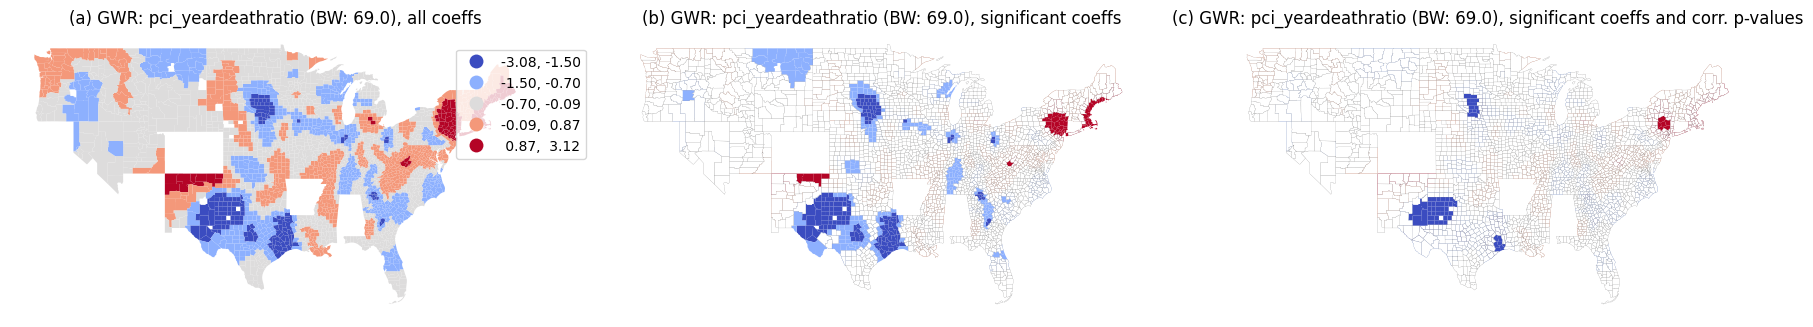

In [243]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18,6))

combine_gwr.plot(column='gwr_yearfb', cmap = 'coolwarm', linewidth=0.01, scheme = 'FisherJenks', k=5, legend=True, legend_kwds={'bbox_to_anchor':(1.10, 0.96)},  ax=axes[0])
combine_gwr.plot(column='gwr_yearfb', cmap = 'coolwarm', linewidth=0.05, scheme = 'FisherJenks', k=5, legend=False, legend_kwds={'bbox_to_anchor':(1.10, 0.96)},  ax=axes[1])
combine_gwr[gwr_filtered_t[:,1] == 0].plot(color='white', linewidth=0.05, edgecolor='black', ax=axes[1])


combine_gwr.plot(column='gwr_yearfb', cmap = 'coolwarm', linewidth=0.05, scheme = 'FisherJenks', k=5, legend=False, legend_kwds={'bbox_to_anchor':(1.10, 0.96)},  ax=axes[2])
combine_gwr[gwr_filtered_tc[:,1] == 0].plot(color='white', linewidth=0.05, edgecolor='black', ax=axes[2])

plt.tight_layout()

axes[0].axis("off")
axes[1].axis("off")
axes[2].axis("off")

axes[0].set_title('(a) GWR: pci_yeardeathratio (BW: ' + str(gwr_bw) +'), all coeffs', fontsize=12)
axes[1].set_title('(b) GWR: pci_yeardeathratio (BW: ' + str(gwr_bw) +'), significant coeffs',     fontsize=12)
axes[2].set_title('(c) GWR: pci_yeardeathratio (BW: ' + str(gwr_bw) +'), significant coeffs and corr. p-values',     fontsize=12)
plt.show()

In [ ]:
gwr_before830bw,gwr_before830results,R2=gwr('bef830_deaths_ratio')
combine_gwr['bef830gwr_R2'] = gwr_results.localR2
fig, ax = plt.subplots(figsize=(6, 6))
combine_gwr.plot(column='bef830gwr_R2', cmap = 'coolwarm', linewidth=0.01, scheme = 'FisherJenks', k=5, legend=True, legend_kwds={'bbox_to_anchor':(1.10, 0.96)},  ax=ax)
ax.set_title('Local R2', fontsize=12)
ax.axis("off")
#plt.savefig('myMap.png',dpi=150, bbox_inches='tight')
plt.show()


In [ ]:
combine_gwr['gwr_bf830intercept'] = gwr_results.params[:,0]
combine_gwr['gwr_bf830fb']        = gwr_results.params[:,1]
gwr_bf830filtered_t = gwr_before830results.filter_tvals(alpha = 0.05)
# Filter t-values: corrected alpha due to multiple testing
gwr_bf830filtered_tc = gwr_before830results.filter_tvals()

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18,6))

combine_gwr.plot(column='gwr_bf830fb', cmap = 'coolwarm', linewidth=0.01, scheme = 'FisherJenks', k=5, legend=True, legend_kwds={'bbox_to_anchor':(1.10, 0.96)},  ax=axes[0])
combine_gwr.plot(column='gwr_bf830fb', cmap = 'coolwarm', linewidth=0.05, scheme = 'FisherJenks', k=5, legend=False, legend_kwds={'bbox_to_anchor':(1.10, 0.96)},  ax=axes[1])
combine_gwr[gwr_filtered_t[:,1] == 0].plot(color='white', linewidth=0.05, edgecolor='black', ax=axes[1])


combine_gwr.plot(column='gwr_bf830fb', cmap = 'coolwarm', linewidth=0.05, scheme = 'FisherJenks', k=5, legend=False, legend_kwds={'bbox_to_anchor':(1.10, 0.96)},  ax=axes[2])
combine_gwr[gwr_filtered_tc[:,1] == 0].plot(color='white', linewidth=0.05, edgecolor='black', ax=axes[2])

plt.tight_layout()

axes[0].axis("off")
axes[1].axis("off")
axes[2].axis("off")

axes[0].set_title('(a) GWR: pci_bf830deathratio (BW: ' + str(gwr_bw) +'), all coeffs', fontsize=12)
axes[1].set_title('(b) GWR: pci_bf830deathratio (BW: ' + str(gwr_bw) +'), significant coeffs',     fontsize=12)
axes[2].set_title('(c) GWR: pci_bf830deathratio (BW: ' + str(gwr_bw) +'), significant coeffs and corr. p-values',     fontsize=12)
plt.show()